In [120]:
import tensorflow as tf
import os

import cv2 
from PIL import Image
import imghdr
import numpy as np
from matplotlib import pyplot as plt


In [151]:
#Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [152]:
data_dir = 'data'
image_exts = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)

            if tip not in image_exts:
                print("Image ext not in list {}".format(image_path))
                print("tip: {}".format(tip))
                os.remove(image_path)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

In [164]:
img = cv2.imread(os.path.join('data','blue_dreams','48b0ca_c3c6ed33d29d4d3db6229f8edb345e5emv2.jpg'))

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BAYER_BG2BGR))
# plt.imshow(cv2.cvtColor(img,cv2.COLOR_BAYER_BG2RGB))

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\demosaicing.cpp:1723: error: (-215:Assertion failed) scn == 1 && (dcn == 3 || dcn == 4) in function 'cv::demosaicing'


In [153]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 1535 files belonging to 2 classes.


In [154]:
# Class 0 = Blue Dreams
#Class 1 = Cherry Shrimp

batch[1]

array([1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1])

In [156]:
scaled_data = data.map(lambda x,y: (x/255, y))
scaled_iterator =data.as_numpy_iterator()
batch = scaled_iterator.next()
# scaled_iterator.next()

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\demosaicing.cpp:1723: error: (-215:Assertion failed) scn == 1 && (dcn == 3 || dcn == 4) in function 'cv::demosaicing'


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\demosaicing.cpp:1693: error: (-215:Assertion failed) depth == CV_8U || depth == CV_16U in function 'cv::demosaicing'


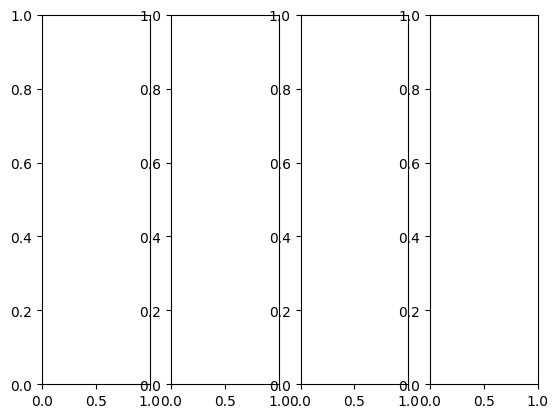

In [142]:
fig, ax = plt.subplots(ncols=4)
# fig.set_size_inches(20,20)
for idx, img in enumerate(batch[0][:4]):

    ax[idx].imshow(cv2.cvtColor(img,cv2.COLOR_BAYER_BG2GRAY))
    ax[idx].set_title(batch[1][idx])

In [127]:
train_size = int(len(scaled_data)*.7)
validation_size = int(len(scaled_data)*.2)
test_size = int(len(scaled_data)*.1)


train = data.take(train_size)
validation = data.skip(train_size).take(validation_size)
test = data.skip(train_size+validation_size).take(test_size)

In [128]:
# from tensorflow.keras.models import Functional This is probably what I want to use for multiple input and output types
from tensorflow.keras.models import Sequential # 1 data in 1 data out, flows top to bottom
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input

In [129]:

# import tensorflow as tf
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), strides=1, activation='relu', input_shape=(416, 416, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), strides=1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), strides=1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))



In [130]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [131]:
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 414, 414, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 207, 207, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 205, 205, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 102, 102, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │    20,480,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,494,849 (78.18 MB)

 Trainable params: 20,494,849 (78.18 MB)

 Non-trainable params: 0 (0.00 B)

In [132]:
log_dir = 'logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
history = model.fit(train, epochs=20, validation_data=validation, callbacks=[tensorboard_callback])


Epoch 1/20


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_9" is incompatible with the layer: expected axis -1 of input shape to have value 80000, but received input with shape (None, 28800)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 256, 256, 3), dtype=float32)
  • training=True
  • mask=None

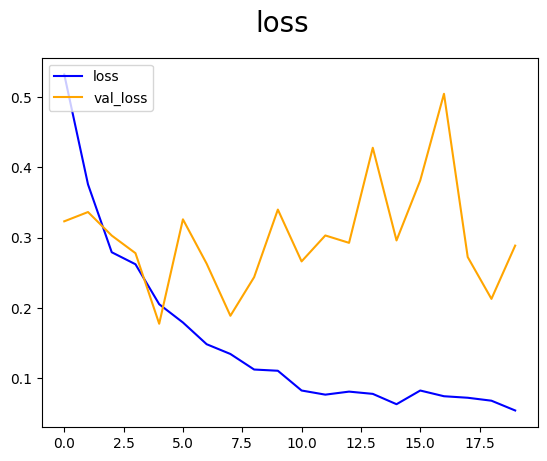

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

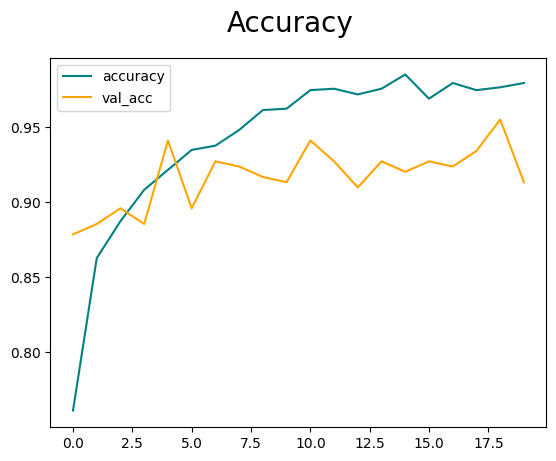

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_acc')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()